# TSMAI sheet01 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd

import scipy.signal as sg

/Users/samrouppe/opt/anaconda3/envs/3dcv-students/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
class Data:
    """
    Data treatment class
    Parameters:
        path (str) : path for loading data
        skiprows (int) : skipping header rows default 1
    """
    
    def __init__(self, path: str, elements: list=None, raw=None, **kwargs):
        if type(raw) == type(None):
            self.path = path
            if path.endswith('.csv'):
                self.elements = elements
                self.raw = np.loadtxt(self.path,**kwargs).T
            elif path.endswith('.xls'):
                df = pd.read_excel('investment.xls')
                self.elements = df.columns.tolist()
                self.raw = df.to_numpy().T
        else:
            self.raw = raw

        if len(np.shape(self.raw)) != 2:
            self.raw = np.expand_dims(self.raw, axis=0)

    def get_raw(self):
        return self.raw
    
    def get_index(self, indx):
        return self.raw[indx]
    
    def std_for_plot(self, indx):
        self.standardized = ( ( self.raw[indx].T - np.mean(self.raw[indx],axis=1) )/np.var(self.raw[indx],axis=1) ).T

        if len(np.shape(self.standardized)) != 2:
            self.standardized = np.expand_dims(self.standardized, axis=0)

        print(f"standardized array of the indexes created, shape : {np.shape(self.standardized)}")
        return self.standardized
    

    def calc_correlations(self, indx: list, dt_lag: int=1):
        pairs = list(combinations(indx,2))
        correlations = np.zeros(len(pairs)) # = len(indx)*(len(indx)-1)/2

        for i,pair in enumerate(pairs):
            correlations[i] = Timelagged_Correlation(self.raw[pair[0]],self.raw[pair[1]],dt_lag=dt_lag)

        return pairs, correlations
    

    def detrend_indx(self, indx):
        self.detrened = sg.detrend(self.raw[indx]) # not sure if works for multi dim data arrays, need to check

        if len(np.shape(self.detrened)) != 2:
            self.detrened = np.expand_dims(self.detrened, axis=0)

        return self.detrened
    
    
    def stationarity_check(self, indx: int, windowsize: int, windowstep: int=1,strong=False,**kwargs):
        if not hasattr(self, 'detrened'):
            self.detrened = self.detrend_indx(self, indx)

        arr = self.detrened[indx]
        if strong:
            pass # calculating higher moments (and maybe comparing histogram plots visually)
        else:
            mean_std,  std_std, acorr_std, means, stds, acorrs = Stationarity(arr, windowsize, windowstep=windowstep)

            return mean_std,  std_std, acorr_std, means, stds, acorrs

    def autocorrelation_func(self, indx: int):
        if not hasattr(self, 'detrened'):
            self.detrened = self.detrend_indx(self, indx)

        arr = self.detrened[indx]
        
        n_measure = len(range(0,len(arr)-1))

        acorrs = np.zeros(n_measure)

        for i in range(0,len(arr)-1):
            acorrs[i] = AutoCorrelation(arr,dt_lag=i)

        return acorrs 
        


    def return_map(self, indx: int, tau: int, std: bool=False, title: str=None, cmap='viridis',ax=None):
        """
        Plot a return map (x_n vs x_{n+1})
        """
        if std:
            if not hasattr(self, 'standardized'):
                self.standardized = self.std_for_plot(self, indx)

            x = self.standardized[indx-1]
        else:
            x = self.raw[indx]

        # Create return map coordinates (lag=tau)
        x_n = x[:-tau]
        x_n1 = x[tau:]
        n_points = len(x_n)
        
        # Create axes if not provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        else:
            fig = ax.figure
        
        # Create color values (time progression from start to end)
        color_time = np.linspace(0, 1, n_points)  # Normalized time [0, 1]
        
        # Scatter plot with time-based coloring
        sc = ax.scatter(x_n, x_n1, 
                        c=color_time,         # Color maps to time progression
                        cmap=cmap, 
                        alpha=0.4, 
                        marker='o', 
                        edgecolors='none')
        
        # Labels and styling
        ax.set_xlabel('$x_n$')
        ax.set_ylabel(f'x_(n+{tau})')
        ax.set_title(f'Return Map of {title}, tau = {tau}')
        ax.grid(True)
        
        # Add colorbar (representing normalized time)
        cbar = fig.colorbar(sc, ax=ax, label='Normalized Time')
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Start', 'End'])
        
        
        return ax



In [3]:
def Timelagged_Correlation(x,y,dt_lag=1):
    """
    calculating time lagged Correlation between x and y
    """
    if dt_lag == 0:
        x_trunc, y_trunc = x, y
    else:
        x_trunc, y_trunc = x[:-dt_lag], y[dt_lag:]
    mean_x, mean_y = np.mean(x_trunc), np.mean(y_trunc)
    std_x, std_y = np.std(x_trunc,ddof=1), np.std(y_trunc,ddof=1)

    xt = x_trunc - mean_x
    ytdt = y_trunc - mean_y

    xcov_y = np.mean(xt * ytdt)

    xcorr_y = xcov_y / ( std_x * std_y)

    return xcorr_y


def Stationarity(arr: np.ndarray, windowsize: int, windowstep: int=1,strong=False,**kwargs):    
    if strong:
        pass
    else:
        iter = int(np.floor((len(arr)-windowsize)/windowstep) + 1)

        means = np.zeros(iter)
        stds = np.zeros(iter)
        acorrs = np.zeros(iter)

        for i in range(iter):
            window = arr[i:i+windowsize]
            mean, std, acorr = np.mean(window), np.std(window), Timelagged_Correlation(window,window)

            means[i], stds[i], acorrs[i] = mean, std, acorr
    
        mean_std,  std_std, acorr_std = np.std(means), np.std(stds), np.std(acorrs)

        return mean_std,  std_std, acorr_std, means, stds, acorrs 

## Task 1.1

standardized array of the indexes created, shape : (3, 1827)


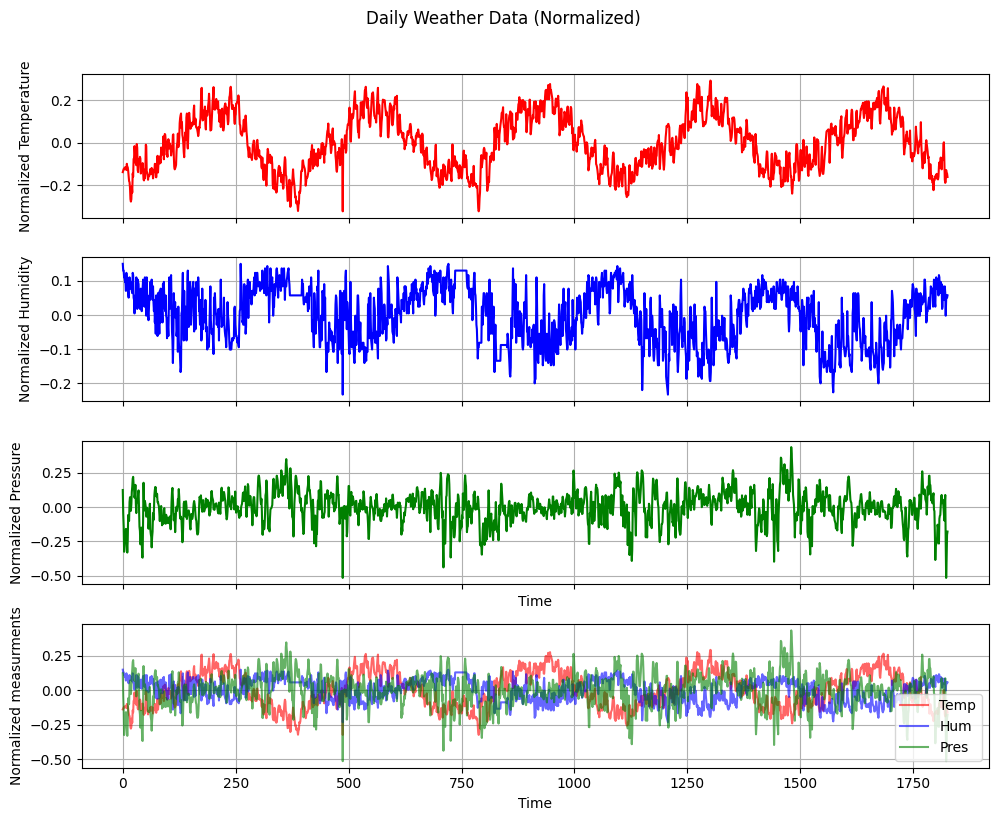

In [4]:
# row 1 in file : Time,Temperature,Humidity,Pressure
dailyweather = Data("dailyweather.csv",elements=["Year","Temerature","Humidity","Pressure"],skiprows=1,delimiter=",")
#print(np.shape(dailyweather_raw))

T_plot,H_plot,P_plot = dailyweather.std_for_plot([1,2,3])

# Create figure with 3 vertical subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot Temperature
ax1.plot(T_plot, color='red')
ax1.set_ylabel('Normalized Temperature')
ax1.grid(True)

# Plot Humidity
ax2.plot(H_plot, color='blue')
ax2.set_ylabel('Normalized Humidity')
ax2.grid(True)

# Plot Pressure
ax3.plot(P_plot, color='green')
ax3.set_ylabel('Normalized Pressure')
ax3.set_xlabel('Time')
ax3.grid(True)

# Plot Pressure
ax4.plot(T_plot, alpha=0.6, color='red', label="Temp")
ax4.plot(H_plot, alpha=0.6, color='blue', label="Hum")
ax4.plot(P_plot, alpha=0.6, color='green', label="Pres")
ax4.set_ylabel('Normalized measurments')
ax4.set_xlabel('Time')
ax4.legend()
ax4.grid(True)

# Main title
plt.suptitle('Daily Weather Data (Normalized)', y=1.02, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Visually there sems to be some correlation in between the humidity and temperature. They seem to have similar periodicity, but in oposite phase, althoug the Humidity visually has higher variance, ecpesially when temperature is high. The pressure does not look very correlated visually.

## Task 1.2

In [5]:
pairs, correlations = dailyweather.calc_correlations([1,2,3],dt_lag=1)

for i,pair in enumerate(pairs):
    print(f"Correlation betweem {dailyweather.elements[pair[0]]} and {dailyweather.elements[pair[1]]} = {correlations[i]}")


Correlation betweem Temerature and Humidity = -0.5479803837982338
Correlation betweem Temerature and Pressure = -0.02335630046873728
Correlation betweem Humidity and Pressure = 0.0008288768612681512


The calculated correlation between Temp and Humidity confirms there is some correlation between them, the others seem to have little to no correlation.

## Task 1.3

We expect the first return map to reflect that from day to day the avereage temperature is not changing to much, so we expect a line. The same for the other measures. For the return maps of longer intervals, we expect them to be less correlated, so more like a scattering points randomly, for the yearly one, we expect it to be more correlated, more like a line as well.

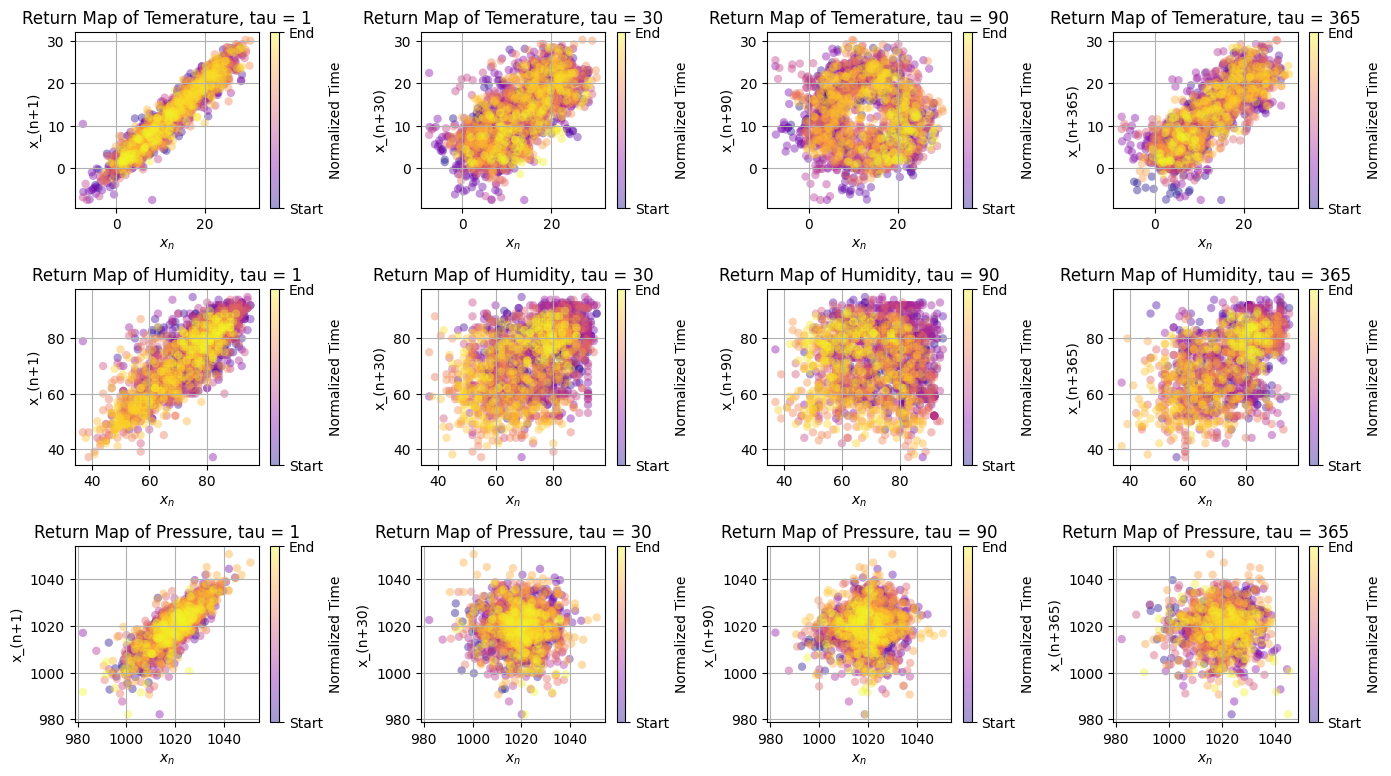

In [6]:
days = [1,30,90,365]

fig = plt.figure(figsize=(14, 10))
plt_indx = 1

for i in range(1,4):
    for j in range(1,len(days)+1):
        ax = fig.add_subplot(len(days),len(days),plt_indx)
        dailyweather.return_map(i,days[j-1],title=dailyweather.elements[i],cmap="plasma",ax=ax)
        plt_indx += 1

plt.tight_layout()
plt.show()

We see that the first return maps are as expected quite correlated. For the others they are more randomly scattered. Only the Temperature one month and one year return map also looks to be more correlated. 

## Taks 1.4

From the return maps climate change is to us not apparent, other than when we include the time coloration, i.e. the earlier scattered points have different color to the ones later, we see the bright orange dots which at later times are shifted towards the top right corner. This indicates warmer temperatures. This is especially apparent in return map 365, maybe because this removes shorter term trends/ seasonalities.

## Task 2

## Task 2.1

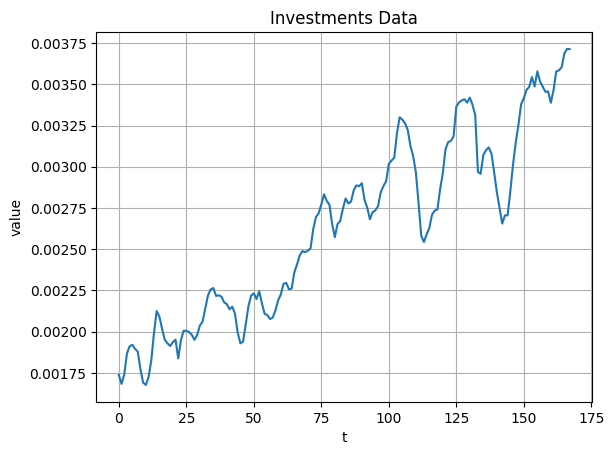

In [7]:
investments = Data('investment.xls')

TS = investments.get_index(0)

plt.plot(TS)
plt.grid(True)
plt.xlabel("t")
plt.ylabel("value")
plt.title("Investments Data")
plt.show()

Since we see there is a constant offset in the data we need to fit a line $\text{investment}(t_\textit{n}) = mt_\textit{n} + b$ otherwise, the data will not be properly centered around zero after detrending.

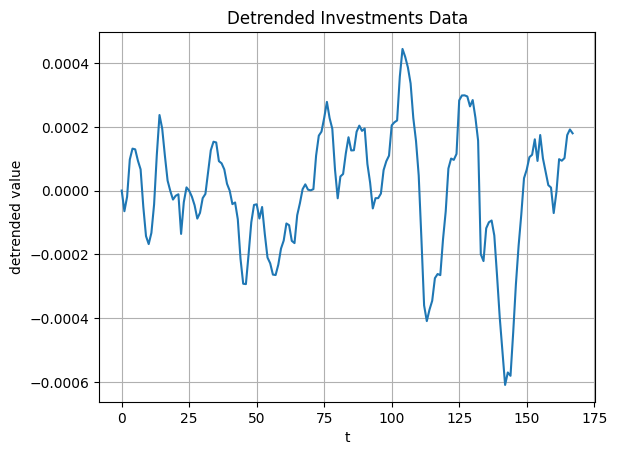

In [8]:
detrended_TS = investments.detrend_indx(0)[0]

plt.plot(detrended_TS)
plt.xlabel("t")
plt.ylabel("detrended value")
plt.title("Detrended Investments Data")
plt.grid(True)
plt.show()

## Task 2.2
### a)

### Stationarity 

#### Weak Stationarity

Weak stationarity fullfills:

- $\mathbb{E}[X] = \mu_t = \text{const}, \ \forall t$
- $\text{Acorr}(X_t, X_{t+h}) = \text{Acorr}(\Delta t), \ \forall t,\Delta t$

In words the two first moments, and the auto correlation should be constant in time. 

#### Strong Stationarity

Strong stationarity fullfills:

- $\text{P}(\{X_t|t_0 \leq t \leq t_1\}) = \text{P}(\{X_t|t_0 + \Delta t \leq t \leq t_1 + \Delta t \}), \ \forall t_0, t, \Delta t \geq 0$

In words the entire probability distribution should be constant in time. For this condition all moments of the probability distributions must be constant in time.

### b)

Investigating weak stationarity, with rolling windows to compute the moments, then plotting and calculating the standard deviation of them to determine if they are approximately constant.

sample size: 30
standard deviation of means: 8.011545804191129e-05
standard deviation of standard deviations: 7.157677907051263e-05
standard deviation of time lagged autocorrelation: 0.056642632462190166


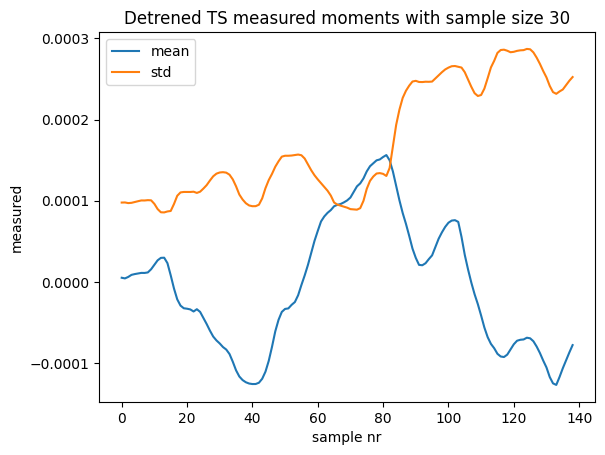

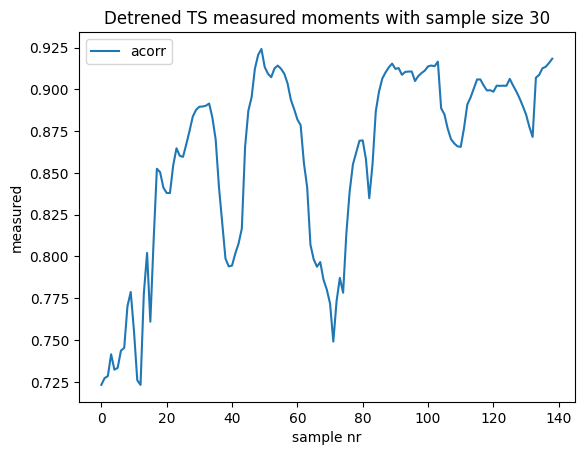

In [9]:
windowsize = 30
mean_std,  std_std, acorr_std, means, stds, acorrs = investments.stationarity_check(0,windowsize)

print(f'sample size: {windowsize}')
print(f'standard deviation of means: {mean_std}')
print(f'standard deviation of standard deviations: {std_std}')
print(f'standard deviation of time lagged autocorrelation: {acorr_std}')


plt.plot(means,label='mean')
plt.plot(stds,label='std')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"Detrened TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

plt.plot(acorrs,label='acorr')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"Detrened TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

The moments have low standard deviations and the plots appear not ot follow any particular trend, also apparent when adjusting the sample size. This leads us to believe the detrended data is at least close to weakly stationary.

sample size: 30
standard deviation of means: 8.672366744620972e-06
standard deviation of standard deviations: 1.9871809726179096e-05
standard deviation of time lagged autocorrelation: 0.10489107539502342


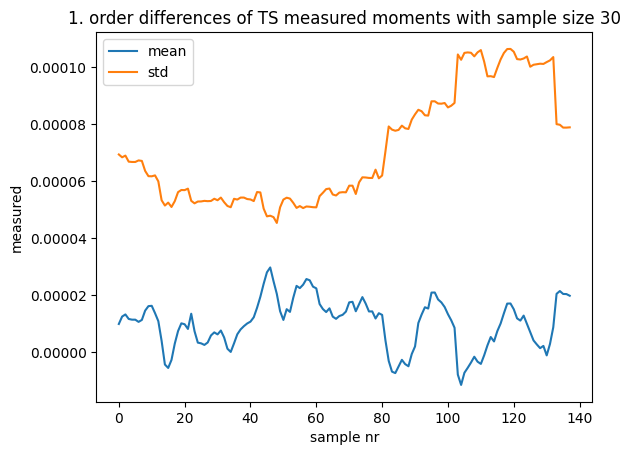

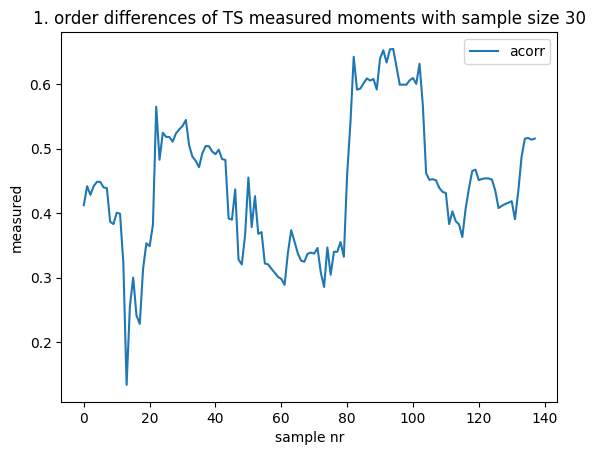

In [10]:
windowsize = 30

lag = 1
first_diff = TS[lag:]-TS[:-lag]

mean_std,  std_std, acorr_std, means, stds, acorrs = Stationarity(first_diff,windowsize)

print(f'sample size: {windowsize}')
print(f'standard deviation of means: {mean_std}')
print(f'standard deviation of standard deviations: {std_std}')
print(f'standard deviation of time lagged autocorrelation: {acorr_std}')

plt.plot(means,label='mean')
plt.plot(stds,label='std')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"1. order differences of TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

plt.plot(acorrs,label='acorr')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"1. order differences of TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

The moments have low standard deviations and the plots appear not ot follow any particular trend, also apparent when adjusting the sample size. This leads us to believe the 1. order differences of the data is stationary.

sample size: 30
standard deviation of means: 1.7014330432319293e-05
standard deviation of standard deviations: 3.550384124924462e-05
standard deviation of time lagged autocorrelation: 0.06463181353813517


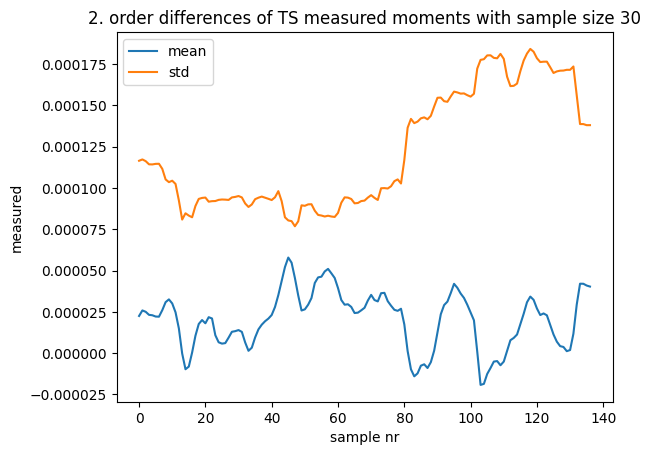

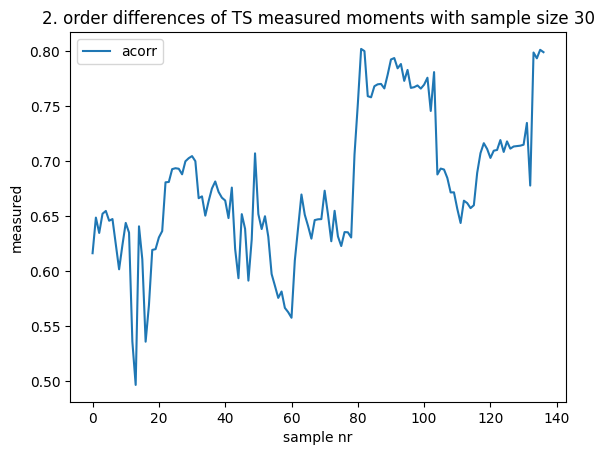

In [11]:
windowsize = 30

lag = 2
second_diff = TS[lag:]-TS[:-lag]

mean_std,  std_std, acorr_std, means, stds, acorrs = Stationarity(second_diff,windowsize)

print(f'sample size: {windowsize}')
print(f'standard deviation of means: {mean_std}')
print(f'standard deviation of standard deviations: {std_std}')
print(f'standard deviation of time lagged autocorrelation: {acorr_std}')


plt.plot(means,label='mean')
plt.plot(stds,label='std')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"2. order differences of TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

plt.plot(acorrs,label='acorr')
plt.ylabel('measured')
plt.xlabel('sample nr')
plt.title(f"2. order differences of TS measured moments with sample size {windowsize}")
plt.legend()
plt.show()

The moments have low standard deviations and the plots appear not ot follow any particular trend, also apparent when adjusting the sample size. This leads us to believe the 2. order differences of the data also is stationary.

## task 2.3

In [ ]:
def AutoCorrelation(x,dt_lag=1):
    """
    autocorrelation func
    """
    if dt_lag == 0:
        x_trunc, x1_trunc = x, x
    else:
        x_trunc, x1_trunc = x[:-dt_lag], x[dt_lag:]
    mean_x = np.mean(x)
    std_x = np.std(x)

    xt = x_trunc - mean_x
    xtdt = x1_trunc - mean_x

    acov = np.mean(xt * xtdt)

    acorr = acov / ( std_x ** 2)

    return acorr

In the timelagged_correlation function (which is equivalent to autocorrelation when passing the same array twice) the mean and standard deviation is calculated for the arrays truncated by the time lag, for this to be valid weak stationarity is assumed. The autocorrelation function for this task does not calculate the local means and stds, and stationaity is not required. Below the two functions are calculated for time lag 0 and 1. For 0 we expect 1. 

In [17]:
acorr = Timelagged_Correlation(detrended_TS,detrended_TS,dt_lag=0)
print(f'Autocorrelation with lag = 0 and calc with func Timelagged_Correlation: {acorr}')

acorr = AutoCorrelation(detrended_TS,dt_lag=0)
print(f'Autocorrelation with lag = 0 and calc with func AutoCorrelation: {acorr}')

acorr = Timelagged_Correlation(detrended_TS,detrended_TS,dt_lag=1)
print(f'Autocorrelation with lag = 1 and calc with func Timelagged_Correlation: {acorr}')

acorr = AutoCorrelation(detrended_TS,dt_lag=1)
print(f'Autocorrelation with lag = 1 and calc with func AutoCorrelation: {acorr}')

Autocorrelation with lag = 0 and calc with func Timelagged_Correlation: 0.9940476190476191
Autocorrelation with lag = 0 and calc with func AutoCorrelation: 0.9999999999999998
Autocorrelation with lag = 1 and calc with func Timelagged_Correlation: 0.9220941488409261
Autocorrelation with lag = 1 and calc with func AutoCorrelation: 0.9307861011142943


(168,)


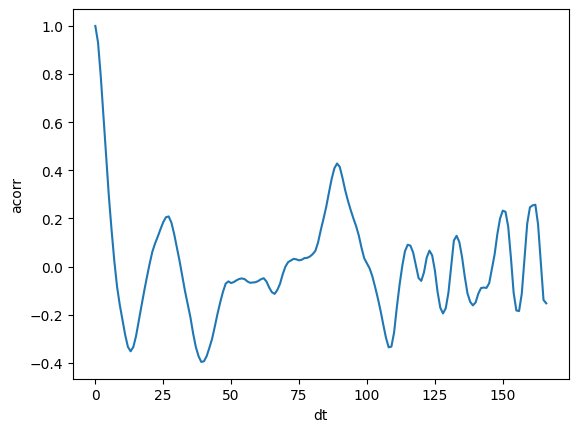

In [14]:
acorr_func = investments.autocorrelation_func(0)

plt.plot(acorr_func)
plt.xlabel('dt')
plt.ylabel('acorr')
plt.show()

There seems to be a monthly buisness cycle, but even stronger a around 3 month buisness cycle, this is maybe related to the 4 quarters that we have heared about in the buisness world.

## Task 3

### task 3.1

Auto Regressive time series of order p: 

$$\text{AR}(p) : x_t = a_0 + \sum_{i=1}^p a_i x_{t-i} + \epsilon_t $$

In [15]:
class AR_model:
    def __init__(self, coeff: list, init: list, noise: str='normal',**kwargs):
        self.order = len(coeff)-1
        self.coeff = np.array(coeff)
        self.noise = noise
        self.config = kwargs
        self.init = np.array(init)
        self.xn_temp = self.init
        self.xn = None

    def __call__(self):
        if self.noise == 'normal':
            coeffs = self.coeff[-1:0:-1]
            xt = self.coeff[0] + coeffs @ self.xn_temp[-self.order:] + np.random.normal(**self.config) 
            xt = np.array(xt)
            if type(self.xn) != type(None):
                self.xn = np.concatenate((self.xn, xt))
                self.xn_temp = np.concatenate((self.xn_temp, xt))
            else:
                self.xn = xt
                self.xn_temp = np.concatenate((self.xn_temp, xt))

            return np.array(xt)
        
    def __call__(self, init: list):
        init = np.array(init)
        if self.noise == 'normal':
            coeffs = self.coeff[-1:0:-1]
            xt = self.coeff[0] + coeffs @ init + np.random.normal(**self.config) 
            xt = np.array(xt)
            if type(self.xn) != type(None):
                self.xn = np.concatenate((self.xn, xt))
                self.xn_temp = np.concatenate((self.xn_temp, xt))
            else:
                self.xn = xt
                self.xn_temp = np.concatenate((self.xn_temp, xt))

            return np.array(xt)

        
    def __call__(self, length: int):
        xt_arr = np.zeros(length)
        
        if self.noise == 'normal':
            for i in range(length): 
                coeffs = self.coeff[-1:0:-1] # reverse the coeff to ensure, a_i*x_t-i
                xt_arr[i] = self.coeff[0] + coeffs @ self.xn_temp[-self.order:] + np.random.normal(**self.config)[0] 
                self.xn_temp = np.append(self.xn_temp, xt_arr[i])

            if type(self.xn) != type(None):
                self.xn = np.concatenate((self.xn, xt_arr))
            else:
                self.xn = xt_arr

            return np.array(xt_arr)

### Task 3.2



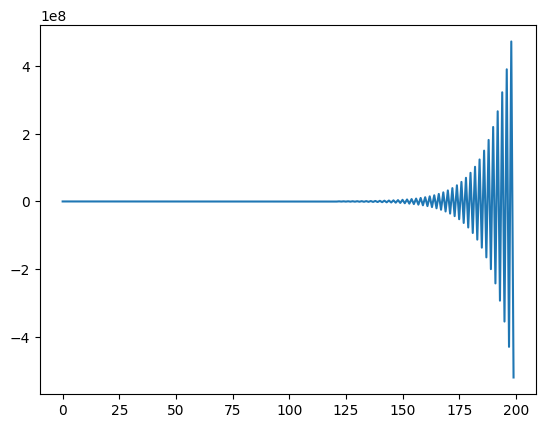

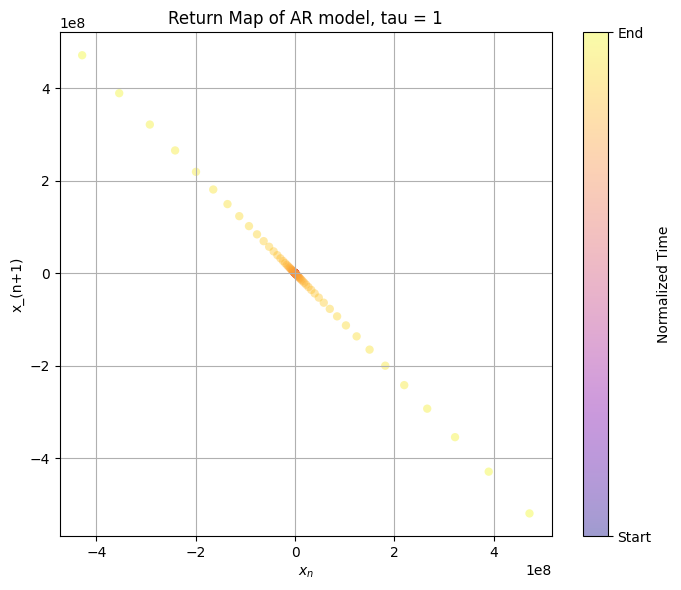

In [22]:
AR4 = AR_model([0,-0.8,0,0,0.4],[0,0,0,0],loc=0.0, scale=1.0, size=1)

TS_200 = AR4(200)

AR_TS_DATA = Data('dum',raw=TS_200)

plt.plot(TS_200)
plt.show()

fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)
AR_TS_DATA.return_map(0, tau=1, title="AR model", cmap='plasma',ax = ax)
#ax.plot(range(int(-1e8),int(1e8),int(1e7)),-0.8*np.array(range(int(-1e8),int(1e8),int(1e7))))

plt.tight_layout()
plt.show()

The time series produced by the AR model, occilates with a constant frequency, and the amplitude increases slowly at first before blowing up.